# Analisis Prediktif: Prediksi Harga Rumah di Jakarta Selatan
<hr>

### *Oleh: [Panji Arlin Saputra](https://www.dicoding.com/users/panjiarlins)*
### *Proyek Submission 1: Machine Learning Terapan Dicoding*
<hr>

## **Pendahuluan**
Pada proyek ini, topik yang dibahas adalah mengenai perniagaan yang dibuat untuk memprediksi data harga jual rumah di Jakarta Selatan. Proyek ini dibuat untuk proyek Submission 1 - Machine Learning Terapan Dicoding.

# **1. Mengimpor pustaka/modul python yang dibutuhkan**

In [1]:
# Memasang modul scikit-learn terbaru
!pip install -U scikit-learn

     |████████████████████████████████| 23.1 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Untuk pembuatan model
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# Untuk evaluasi model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# **2. Mempersiapkan Dataset**

## **2.1 Menyiapkan kredensial akun Kaggle**

In [3]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

## **2.2 Mengunduh dan Menyiapkan Dataset**

Informasi Dataset:

Jenis | Keterangan
----- | -----
Sumber | [Kaggle Dataset: Daftar Harga Rumah](https://www.kaggle.com/wisnuanggara/daftar-harga-rumah)
Jenis dan Ukuran Berkas | XLSX (118 kB)


In [4]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download wisnuanggara/daftar-harga-rumah

  0% 0.00/109k [00:00<?, ?B/s]
100% 109k/109k [00:00<00:00, 44.8MB/s]


In [5]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/daftar-harga-rumah.zip

Archive:  /content/daftar-harga-rumah.zip
  inflating: DATA RUMAH.xlsx         
  inflating: HARGA RUMAH JAKSEL.xlsx  


# **3. Pemahaman Data (Data Understanding)**

## **3.1 Memuat Data pada sebuah Dataframe menggunakan pandas**

In [6]:
# Untuk memuat himpunan data
path = '/content/HARGA RUMAH JAKSEL.xlsx'
rumah = pd.read_excel(path, header=1)

## **3.2 Keterangan kolom pada dataset**

In [7]:
# Menampilkan sample pada dataset
rumah.head(10)

,HARGA,LT,LB,JKT,JKM,GRS,KOTA
0,28000000000,1100,700,5,6,ADA,JAKSEL
1,19000000000,824,800,4,4,ADA,JAKSEL
2,4700000000,500,400,4,3,ADA,JAKSEL
3,4900000000,251,300,5,4,ADA,JAKSEL
4,28000000000,1340,575,4,5,ADA,JAKSEL
5,10000000000,460,300,4,4,ADA,JAKSEL
6,7600000000,278,350,4,4,ADA,JAKSEL
7,5250000000,511,300,3,2,ADA,JAKSEL
8,670000000,70,69,3,2,TIDAK ADA,JAKSEL
9,480000000,66,42,2,1,TIDAK ADA,JAKSEL


In [8]:
# Memuat informasi dataframe
rumah.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   HARGA   1001 non-null   int64 
 1   LT      1001 non-null   int64 
 2   LB      1001 non-null   int64 
 3   JKT     1001 non-null   int64 
 4   JKM     1001 non-null   int64 
 5   GRS     1001 non-null   object
 6   KOTA    1001 non-null   object
dtypes: int64(5), object(2)
memory usage: 54.9+ KB


In [9]:
# Menghitung jumlah data yang kosong pada setiap kolom
rumah.isna().sum()

HARGA    0
LT       0
LB       0
JKT      0
JKM      0
GRS      0
KOTA     0
dtype: int64

In [10]:
# Memuat deskripsi setiap kolom dataframe
rumah.describe().round(2)

,HARGA,LT,LB,JKT,JKM
count,1.001000e+03,1001.00,1001.00,1001.00,1001.00
mean,1.747472e+10,530.50,487.28,4.46,3.94
std,2.079548e+10,531.07,452.87,2.00,1.90
min,4.300000e+08,22.00,38.00,1.00,1.00
25%,6.750000e+09,220.00,300.00,4.00,3.00
50%,1.350000e+10,400.00,411.00,4.00,4.00
75%,2.000000e+10,677.00,600.00,5.00,4.00
max,2.500000e+11,6790.00,10000.00,27.00,27.00


# **4. Persiapan Data (Data Preparation)**

## **4.1 Mengatasi masalah data yang semua nilainya sama pada satu kolom dengan menghapus kolom tersebut**

In [11]:
# Menghapus kolom 'KOTA'
rumah = rumah.drop(['KOTA'], axis=1)

In [12]:
# Mengecek total baris dan kolom dari dataset
rumah.shape

(1001, 6)

## **4.2 Mengatasi masalah data harga yang nilainya terlalu besar dengan membaginya dengan 10<sup>9</sup> agar satuannya nilainya menjadi miliar rupiah**

In [13]:
rumah['HARGA'] = rumah['HARGA'] / 1e9

## **4.3 Menangani _data outliers_**

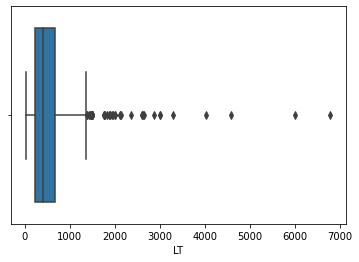

In [14]:
# Memvisualisasikan data Luas Tanah dengan boxplot untuk mendeteksi outliers
sns.boxplot(x=rumah['LT'])

In [15]:
# Menghapus data ouliers dengan metode IQR
Q1 = rumah.quantile(0.25)
Q3 = rumah.quantile(0.75)
IQR = Q3 - Q1
rumah = rumah[~((rumah<(Q1-1.5*IQR))|(rumah>(Q3+1.5*IQR))).any(axis=1)]

In [16]:
# Mengecek ukuran dataset setelah menghapus data outliers
rumah.shape

(802, 6)

## **4.4 Analisis Univariat**

In [17]:
# Membagi fitur pada dataset menjadi dua bagian
numerical_features = ['HARGA', 'LT', 'LB', 'JKT', 'JKM']
categorical_features = 'GRS'

           jumlah sampel  persentase
ADA                  625        77.9
TIDAK ADA            177        22.1


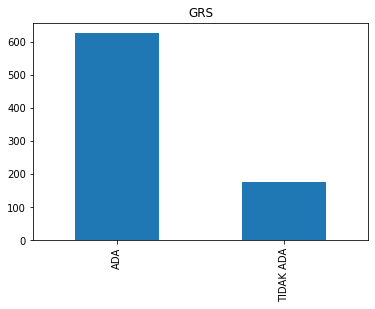

In [18]:
# Fitur kategoris
count = rumah[categorical_features].value_counts()
percent = 100 * rumah[categorical_features].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df)
count.plot(kind='bar', title=categorical_features);

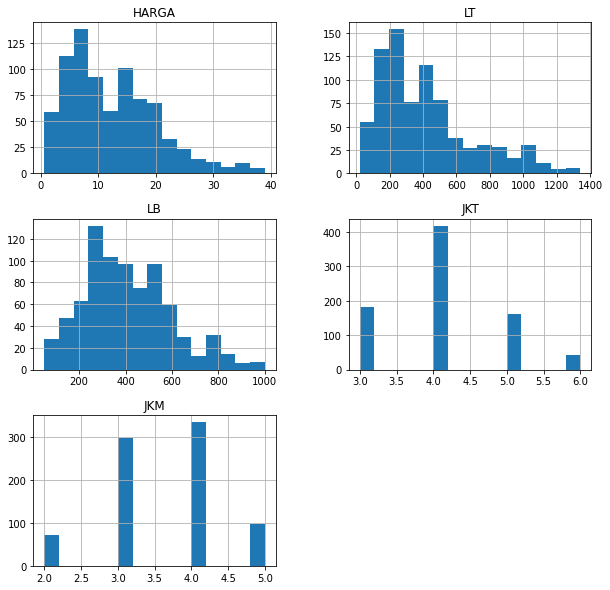

In [19]:
# Fitur numerik
rumah.hist(bins=15, figsize=(10,10))
plt.show()

## **4.5 Analisis Multivariat**

Text(0.5, 1.0, 'Rata-rata "HARGA" Relatif terhadap - GRS')

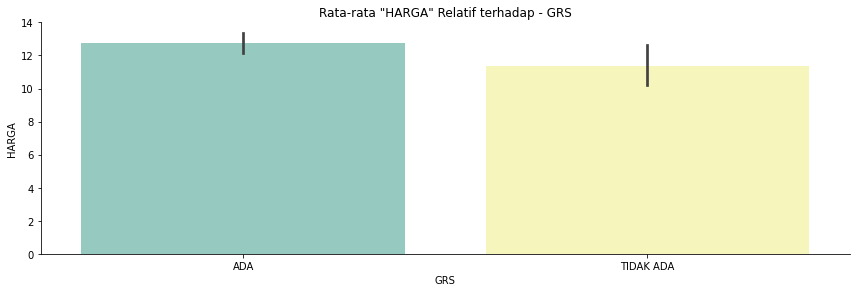

In [20]:
# Fitur kategoris
sns.catplot(x=categorical_features, y='HARGA', kind='bar', dodge=False, height=4, aspect=3,  data=rumah, palette='Set3')
plt.title('Rata-rata "HARGA" Relatif terhadap - {}'.format(categorical_features))

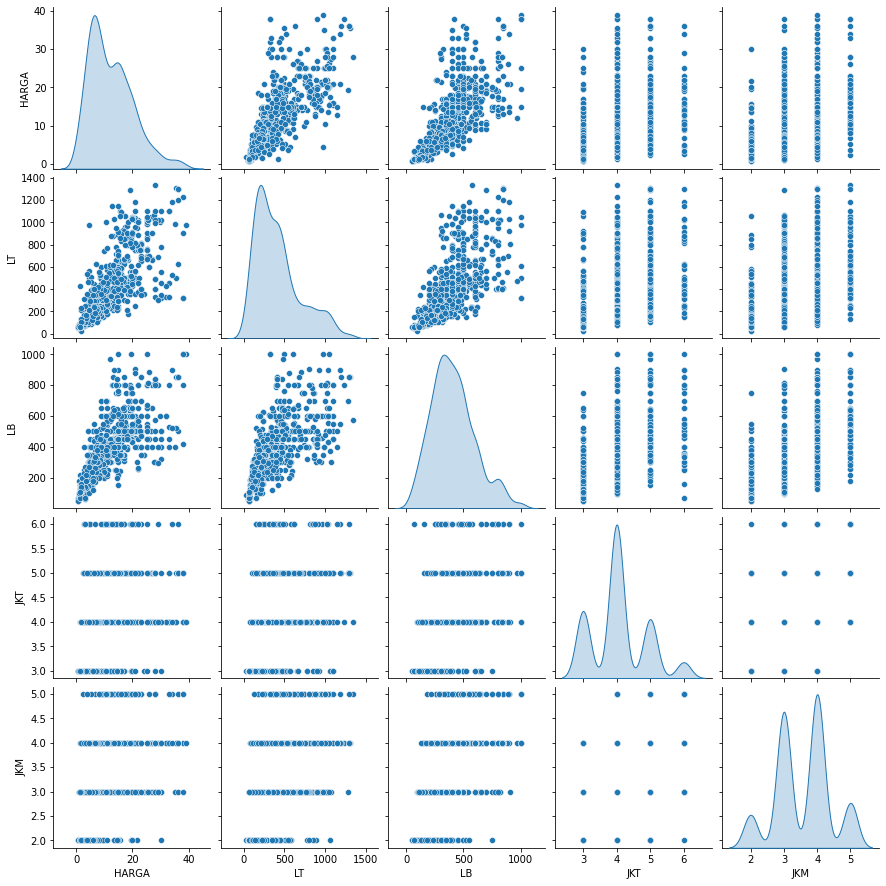

In [21]:
# Mengamati hubungan antar fitur numerik
sns.pairplot(rumah, diag_kind = 'kde')

Text(0.5, 1.0, 'Metrik Korelasi Untuk Fitur Numerik')

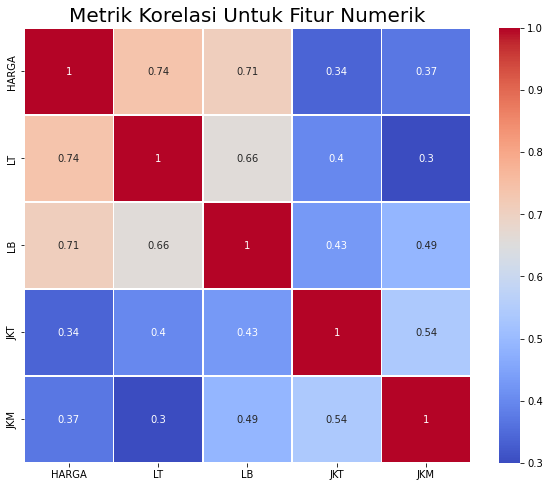

In [22]:
# Mengevaluasi skor korelasi
plt.figure(figsize=(10, 8))
correlation_matrix = rumah.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title('Metrik Korelasi Untuk Fitur Numerik', size=20)

## **4.6 _Encoding_ fitur kategoris**

In [23]:
# Melakukan encoding pada fitur kategoris
rumah = pd.concat([rumah, pd.get_dummies(rumah['GRS'], prefix='GRS', drop_first=True)],axis=1)
rumah.drop(['GRS'], axis=1, inplace=True)
rumah.rename({'GRS_TIDAK ADA':'GRS'}, axis=1, inplace=True)

In [24]:
# Menampilkan dataset setelah dilakukan proses encoding
rumah.head(10)

,HARGA,LT,LB,JKT,JKM,GRS
1,19.00,824,800,4,4,0
2,4.70,500,400,4,3,0
3,4.90,251,300,5,4,0
4,28.00,1340,575,4,5,0
5,10.00,460,300,4,4,0
6,7.60,278,350,4,4,0
7,5.25,511,300,3,2,0
8,0.67,70,69,3,2,1
12,8.50,320,250,4,4,0
13,7.00,384,400,4,4,0


## **4.7 Reduksi Dimensi dengan PCA**

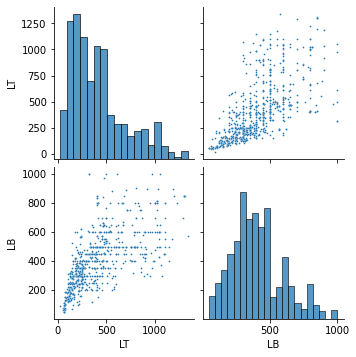

In [25]:
# Mengamati korelasi antara fitur 'LT' dan 'LB'
sns.pairplot(rumah[['LT','LB']], plot_kws={'s': 3});

In [26]:
# Mengamati proporsi informasi pada fitur 'LT' dan 'LB'
pca = PCA(n_components=2, random_state=24)
pca.fit(rumah[['LT','LB']])
princ_comp = pca.transform(rumah[['LT','LB']])
pca.explained_variance_ratio_.round(3)

array([0.857, 0.143])

In [27]:
# Mengaplikasikan PCA pada fitur 'LT' dan 'LB'
pca = PCA(n_components=1, random_state=24)
pca.fit(rumah[['LT','LB']])
rumah['LUAS'] = pca.transform(rumah.loc[:, ('LT','LB')]).flatten()
rumah.drop(['LT','LB'], axis=1, inplace=True)
rumah.head()

,HARGA,JKT,JKM,GRS,LUAS
1,19.0,4,4,0,549.381668
2,4.7,4,3,0,71.247357
3,4.9,5,4,0,-194.866795
4,28.0,4,5,0,889.656628
5,10.0,4,4,0,-12.513581


## **4.8 Melakukan pembagian data pada dataset dengan train_test_split**

In [28]:
X = rumah.drop(['HARGA'], axis=1)
y = rumah['HARGA']

In [29]:
# Melakukan pembagian data dengan train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=24)

In [30]:
# Mengecek jumlah baris pada data latih dan data tes
print(X_train.shape)
print(X_test.shape)

(641, 4)
(161, 4)


## **4.9 Standarisasi nilai data pada fitur numerik dengan StandardScaler**

In [31]:
# Inisialisasi fungsi MinMaxScaler
scaler = StandardScaler()

In [32]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [33]:
# Melihat sampel data hasil standarisasi data
print(f'{X_train[0:5]}\n')
print(X_test[0:5])

[[ 2.4058926   0.5262773  -0.50924653 -0.1727889 ]
 [-0.10989395  1.75745888 -0.50924653  0.07623207]
 [-0.10989395  0.5262773   1.96368547  0.10141172]
 [-0.10989395  0.5262773  -0.50924653  0.61624336]
 [-0.10989395 -0.70490427  1.96368547 -1.19796352]]

[[-0.06194296 -0.68079077 -0.6228411  -1.24091312]
 [-0.06194296  0.51059308 -0.6228411  -0.06763093]
 [ 1.18465914  0.51059308 -0.6228411  -0.58994275]
 [-0.06194296 -0.68079077  1.60554594 -1.12875055]
 [ 1.18465914  1.70197692 -0.6228411   0.44698933]]


In [34]:
# Mengecek jumlah baris pada data latih dan data tes
print(X_train.shape)
print(X_test.shape)

(641, 4)
(161, 4)


# **5. Pembuatan Model**

## **5.1 Model Baseline dengan Algoritma K-Nearest Neighbors**

In [35]:
# Pembuatan model baseline
baseline_knn = KNeighborsRegressor()
baseline_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [36]:
# Mengukur metrik evaluasi pada model baseline terhadap data tes
baseline_knn_mse = mean_squared_error(y_true=y_test, y_pred=baseline_knn.predict(X_test))
baseline_knn_r2 = r2_score(y_true=y_test, y_pred=baseline_knn.predict(X_test))
baseline_knn_mae = mean_absolute_error(y_true=y_test, y_pred=baseline_knn.predict(X_test))

In [37]:
# Menampilkan hasil pengukuran metrik evaluasi
print('MODEL BASELINE KNN\n')
print(f'MSE: {baseline_knn_mse}')
print(f'R-Squared: {baseline_knn_r2}')
print(f'MAE: {baseline_knn_mae}')

MODEL BASELINE KNN

MSE: 27.01735676049689
R-Squared: 0.5923556190864339
MAE: 3.364050931677019


## **5.2 Pengembangan Model K-Nearest Neighbors dengan Hyper Parameter Tuning menggunakan HalvingGridSearchCV**

In [38]:
# Hyperparameter yang akan di tuning
param_grid = {'n_neighbors': range(1,24),
              'p': [1, 2],
              'weights': ["uniform", "distance"],
              'algorithm': ["ball_tree", "kd_tree", "brute"],
              }

In [39]:
# Pencarian parameter terbaik dengan HalvingGridSearchCV
knn_new_param = HalvingGridSearchCV(baseline_knn, param_grid, aggressive_elimination=True).fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
    " but n_samples = %d, n_neighbors = %d" % (n_samples_fit, n_neighbors)
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 8, n_neighbors = 19

  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 696, in score
    y_pred = self.predict(X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py", line 231, in predict
    neigh_dis

In [40]:
# Hasil hyperparameter tuning dengan skor terbaik yang di dapatkan
print(f"Best parameter: {knn_new_param.best_estimator_}")

Best parameter: KNeighborsRegressor(algorithm='ball_tree', n_neighbors=17, weights='distance')


In [41]:
# Penerapan hyperparameter pada model
knn = KNeighborsRegressor(**knn_new_param.best_params_)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=17, weights='distance')

## **5.3 Model Baseline dengan Algoritma Random Forest**

In [42]:
# Pembuatan model baseline
baseline_RF = RandomForestRegressor()
baseline_RF.fit(X_train, y_train)

RandomForestRegressor()

In [43]:
# Mengukur metrik evaluasi pada model baseline terhadap data tes
baseline_RF_mse = mean_squared_error(y_true=y_test, y_pred=baseline_RF.predict(X_test))
baseline_RF_r2 = r2_score(y_true=y_test, y_pred=baseline_RF.predict(X_test))
baseline_RF_mae = mean_absolute_error(y_true=y_test, y_pred=baseline_RF.predict(X_test))

In [44]:
# Menampilkan hasil pengukuran metrik evaluasi
print('MODEL BASELINE RF\n')
print(f'MSE: {baseline_RF_mse}')
print(f'R-Squared: {baseline_RF_r2}')
print(f'MAE: {baseline_RF_mae}')

MODEL BASELINE RF

MSE: 25.37620319531808
R-Squared: 0.6171177390448004
MAE: 3.328566697722567


## **5.4 Pengembangan Model Random Forest dengan Hyper Parameter Tuning menggunakan HalvingGridSearchCV**

In [45]:
# Hyperparameter yang akan di tuning
param_grid = {'n_estimators': range(10,110,5)}

In [46]:
# Pencarian parameter terbaik dengan HalvingGridSearchCV
RF_new_param = HalvingGridSearchCV(baseline_RF, param_grid, aggressive_elimination=True).fit(X_train, y_train)

In [47]:
# Hasil hyperparameter tuning dengan skor terbaik yang di dapatkan
print(f"Best parameter: {RF_new_param.best_estimator_}")

Best parameter: RandomForestRegressor(n_estimators=105)


In [48]:
# Penerapan hyperparameter pada model
RF = RandomForestRegressor(**RF_new_param.best_params_, n_jobs=-1, random_state=24)
RF.fit(X_train, y_train)

RandomForestRegressor(n_estimators=105, n_jobs=-1, random_state=24)

## **5.5 Model Baseline dengan Algoritma Adaptive Boosting**

In [49]:
# Pembuatan model baseline
baseline_boosting = AdaBoostRegressor()
baseline_boosting.fit(X_train, y_train)

AdaBoostRegressor()

In [50]:
# Mengukur metrik evaluasi pada model baseline terhadap data tes
baseline_boosting_mse = mean_squared_error(y_true=y_test, y_pred=baseline_boosting.predict(X_test))
baseline_boosting_r2 = r2_score(y_true=y_test, y_pred=baseline_boosting.predict(X_test))
baseline_boosting_mae = mean_absolute_error(y_true=y_test, y_pred=baseline_boosting.predict(X_test))

In [51]:
# Menampilkan hasil pengukuran metrik evaluasi
print('MODEL BASELINE boosting\n')
print(f'MSE: {baseline_boosting_mse}')
print(f'R-Squared: {baseline_boosting_r2}')
print(f'MAE: {baseline_boosting_mae}')

MODEL BASELINE boosting

MSE: 21.525753934769742
R-Squared: 0.6752142441533355
MAE: 3.13973442151751


## **5.6 Pengembangan Model Adaptive Boosting dengan Hyper Parameter Tuning menggunakan HalvingGridSearchCV**

In [52]:
# Hyperparameter yang akan di tuning
param_grid = {'n_estimators': range(10,101,5), 'learning_rate': [0.01, 0.05, 0.1, 0.5]}

In [53]:
# Pencarian parameter terbaik dengan HalvingGridSearchCV
boosting_new_param = HalvingGridSearchCV(baseline_boosting, param_grid, aggressive_elimination=True).fit(X_train, y_train)

In [54]:
# Hasil hyperparameter tuning dengan skor terbaik yang di dapatkan
print(f"Best parameter: {boosting_new_param.best_estimator_}")

Best parameter: AdaBoostRegressor(learning_rate=0.05, n_estimators=20)


In [55]:
# Penerapan hyperparameter pada model
boosting = AdaBoostRegressor(**boosting_new_param.best_params_, random_state=24)
boosting.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, n_estimators=20, random_state=24)

# **6. Evaluasi Model**

## **6.1 Mengukur metrik evaluasi model pada setiap algoritma yang digunakan**

In [56]:
# Menyiapkan dataframe untuk analisis model
mse = pd.DataFrame(columns=['train', 'test'])
r2 = pd.DataFrame(columns=['train', 'test'])
mae = pd.DataFrame(columns=['train', 'test'])

In [57]:
# Melakukan pengukuran metrik evaluasi
model_dict = {'KNN': knn, 'RF': RF, 'Boosting': boosting}
for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))

    r2.loc[name, 'train'] = r2_score(y_true=y_train, y_pred=model.predict(X_train))
    r2.loc[name, 'test'] = r2_score(y_true=y_test, y_pred=model.predict(X_test))

    mae.loc[name, 'train'] = mean_absolute_error(y_true=y_train, y_pred=model.predict(X_train))
    mae.loc[name, 'test'] = mean_absolute_error(y_true=y_test, y_pred=model.predict(X_test))

## **6.2 Memvisualisasikan hasil pengukuran metrik evaluasi**

             train     test
KNN       0.121385  24.5468
RF         3.58586  25.1174
Boosting   20.0368  21.7588


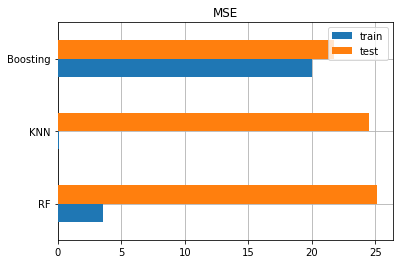

In [58]:
# Metrik evaluasi MSE
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)
ax.set_title('MSE')
print(mse)

             train      test
KNN       0.997974  0.629632
RF         0.94016  0.621022
Boosting  0.665628  0.671698


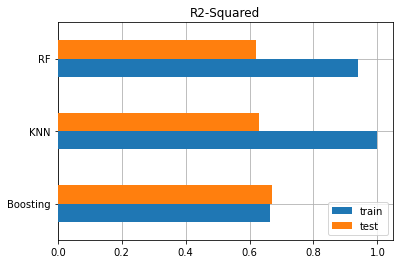

In [59]:
# Metrik evaluasi R2-Squared
fig, ax = plt.subplots()
r2.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)
ax.set_title('R2-Squared')
print(r2)

              train     test
KNN       0.0515861  3.22378
RF          1.25173   3.2936
Boosting     3.0258   3.1066


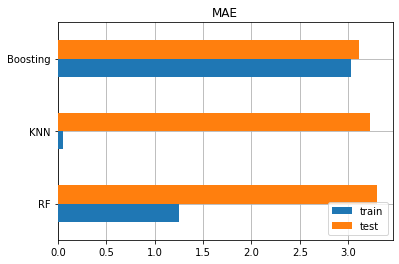

In [60]:
# Metrik Evaluasi MAE
fig, ax = plt.subplots()
mae.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)
ax.set_title('MAE')
print(mae)

## **6.3 Melakukan prediksi dengan data uji**

In [61]:
prediksi = X_test[:2].copy()
pred_dict = {'y_true': y_test[:2]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(2)
 
pd.DataFrame(pred_dict)

,y_true,prediksi_KNN,prediksi_RF,prediksi_Boosting
775,3.5,4.70,3.24,2.56
454,17.0,14.38,16.58,14.31


# **Penutupan**

Model untuk memprediksi harga rumah di Jakarta Selatan telah selesai dibuat dan model ini dapat digunakan untuk memprediksi data yang sebenarnya. Berdasarkan hasil prediksi yang dilakukan terhadap data uji pada proyek ini, dapat disimpulkan bahwa model yang menggunakan algoritma Random Forest menghasilkan hasil prediksi yang lebih baik dibandingkan model yang menggunakan algoritma K-Nearest Neighbors dan Adaptive Boosting.


### **_Referensi_**

* Dokumentasi Scikit-learn: https://scikit-learn.org/stable/modules/classes.html
* Kaggle Dataset Daftar Harga Rumah: https://www.kaggle.com/wisnuanggara/daftar-harga-rumah